In [1]:
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
import json
import os

# Set up Generator utilities

In [2]:
def draw_pixel(color, posx, posy, grids):
    for g in grids:
        g[posy][posx] = color

def draw_filled_square(color, posx, posy, width, grids):
    for g in grids:
        max_y, max_x = g.shape        
        for y in range(posy, min(posy+width, max_y)):
            for x in range(posx, min(posx+width, max_x)):
                if x < 0 or y < 0:
                    continue
                g[y][x] = color

In [3]:
rgbs = ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
        '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25', '#444444']

def to_rgb(rgbstr):
    return int(rgbstr[1:3],16) / 255, int(rgbstr[3:5],16) / 255, int(rgbstr[5:7],16) / 255

# Map a ARC task grid to a 3 channels RGB ndarray, usable in imshow.
def grid_to_rgb(color_idx):
    (h, w) = color_idx.shape if isinstance(color_idx, np.ndarray) else (len(color_idx), len(color_idx[0]))
    new_grid = np.zeros((h, w, 3))
    for r, row in enumerate(color_idx):
        for c, cell in enumerate(row):
            R, G, B = to_rgb(rgbs[cell])
            new_grid[r][c][0] = R
            new_grid[r][c][1] = G
            new_grid[r][c][2] = B
    return new_grid

In [4]:
class ColorPicker:
    def __init__(self, random_generator, num_colors=10):
        self.rng = random_generator
        self.chosen=set()
        self.num_colors=num_colors

    def reset(self):
        self.chosen.clear()
    
    def get(self):
        if len(self.chosen) == self.num_colors:
            raise Exception("Cannot get new color. Max reached.")            
        while True:
            c = self.rng.integers(0, self.num_colors)
            if c not in self.chosen:
                break
        self.chosen.add(c)
        return c

In [5]:
TRAIN_TASK='train'
TEST_TASK='test'

INPUT='input'
OUTPUT='output'
MAX_SIZE=32

In [6]:
def plot_one(ax, grid, label, trim=True):
    ax.imshow(grid_to_rgb(grid))
    ax.set_title(label)

def plot_iopair(task, label):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 7))
    plot_one(ax1, task[INPUT], "")
    plot_one(ax2, task[OUTPUT], "")

# Generators

In [7]:
class TaskGenerator(ABC):
    
    def __init__(self, seed):
        self.rng=np.random.default_rng(seed)
        self.color = ColorPicker(self.rng)    

        self.colors = {}
        self.grid = {}
        self.points = {}        

    @abstractmethod        
    def generate_pair(self):
        pass        

    # Provide a reuse string label will allow previously created colors to be reused.
    # Handy for generating multiple task pairs
    def get_colors(self, num_colors, reuse=None):
        if reuse:
            if not reuse in self.colors: self.colors[reuse] = [ self.color.get() for _ in range(num_colors) ]
            return self.colors[reuse]
        else:
            return [ self.color.get() for _ in range(num_colors) ]

    def get_grid(self, min_size=1, square=True, reuse=None):
        if reuse:
            if not reuse in self.grid: self.grid[reuse] = [ self.randInt(min_size, MAX_SIZE) for _ in range(1 if square else 2) ]
            if sqaure: self.grid[reuse].append(self.grid[reuse][0])
            return self.grid[reuse]
        else:
            result = [ self.randInt(min_size, MAX_SIZE) for _ in range(1 if square else 2) ]  
            if square: result.append(result[0])            
            return result

    # region=(minx, miny, maxx, maxy)
    def get_points(self, num_points, region=(0,0,MAX_SIZE,MAX_SIZE), reuse=None):
        if reuse:
            if not reuse in self.points: 
                self.points[reuse] = [ (self.randInt(region[0],region[2]), self.randInt(region[1],region[3])) for i in range(num_points)]
            return self.points[reuse]
        else:
            return [ (self.randInt(region[0],region[2]), self.randInt(region[1],region[3])) for i in range(num_points)]
        
    # Begin a new batch of pairs for a task.
    # Perform resetting activities ready for a new task.
    def begin_task(self):
        self.reset_colors()
        self.reset_grid()
        self.reset_points()
        # return a new name?

    # any clean up
    def end_task(self):
        pass

    # Clears all memory of previously chosen colors and labels.
    def reset_colors(self):
        self.color.reset()
        self.colors.clear()

    def reset_grid(self):
        self.grid.clear()

    def reset_points(self):
        self.points.clear()
        
    def randInt(self, low, high):
        return self.rng.integers(low, high)               

    # if num_tests is not specified, it will pick 1 95% of the time.
    def generate(self, num_pairs=5, num_tests=None):
        pairs=[]
        
        # Generate all the pairs
        task.begin_task()
        for _ in range(max(num_pairs,3)): # At least 3!
            pairs.append(task.generate_pair())
        task.end_task()

        # Choose how many test cases
        if not num_tests:
            num_tests = 2 if task.randInt(0, 100) < 5 else 1

        data = {
                'train':[pairs[i] for i in range(len(pairs)-num_tests)], 
                'test':[ pairs[-i] for i in range(1, num_tests+1) ] 
        }

        return data


In [8]:
class IdGenerator():

    def __init__(self, seed):
        self.src = [*'0123456789abcdef']
        self.len = 10
        self.rng = np.random.default_rng(seed)
        
    def generate(self):
        return ''.join(self.rng.choice(self.src, size=self.len).tolist())
        

## Circle a Pixel

In [9]:
class CircleAPixel(TaskGenerator):
    
    def __init__(self, seed, max_pts=6):
        super().__init__(seed)
        self.max_pts = max_pts
        
    def generate_pair(self):

        # 'y' is immaterial, reuse just have to be a string to take effect, 
        # but we can have multiple reusable sets key'ed different labels.
        bgcolor, color1, color2 = self.get_colors(3, reuse='y') 

        # Grid
        gridX, gridY = self.get_grid(min_size=5, square=False) # no reuse
        in_grid = np.ones((gridY, gridX), dtype=int) * bgcolor
        ot_grid = np.ones((gridY, gridX), dtype=int) * bgcolor

        # Points
        num_points = 1 if self.max_pts == 1 else self.randInt(1,self.max_pts)
        pt_list = self.get_points(num_points, region=(0,0,gridX,gridY))

        # Generate
        for x, y in pt_list: draw_filled_square(color2, x-1, y-1, 3, [ot_grid])   
        for x, y in pt_list: draw_pixel(color1, x, y, [in_grid, ot_grid])

        # Package
        return {INPUT:in_grid.tolist(), OUTPUT:ot_grid.tolist()}


## Move a Pixel

In [14]:
class MoveAPixelX(TaskGenerator):
    
    def __init__(self, seed, max_pts=6):
        super().__init__(seed)
        self.max_pts = max_pts
        
    def generate_pair(self):

        # 'y' is immaterial, reuse just have to be a string to take effect, 
        # but we can have multiple reusable sets key'ed different labels.
        bgcolor, color1 = self.get_colors(2, reuse='y') 

        # Grid
        gridX, gridY = self.get_grid(min_size=5, square=False) # no reuse
        in_grid = np.ones((gridY, gridX), dtype=int) * bgcolor
        ot_grid = np.ones((gridY, gridX), dtype=int) * bgcolor

        # Points
        num_points = 1 if self.max_pts == 1 else self.randInt(1,self.max_pts)
        pt_list = self.get_points(num_points, region=(0,0,gridX-1,gridY))

        # Generate
        # for x, y in pt_list: draw_filled_square(color2, x-1, y-1, 3, [ot_grid])   
        for x, y in pt_list: draw_pixel(color1, x, y, [in_grid])
        for x, y in pt_list: draw_pixel(color1, x+1, y, [ot_grid]) # move right

        # Package
        return {INPUT:in_grid.tolist(), OUTPUT:ot_grid.tolist()}


# Generate

- CircleAPixel(0)
- CircleAPixel(1,1) "one"
- MoveAPixelX(1,1) "one"

## Test One

processed 0 data/core_knowledge/moveapixelxone/moveapixelxone-78cf02df34.json
processed 100 data/core_knowledge/moveapixelxone/moveapixelxone-d6e0124b41.json
processed 200 data/core_knowledge/moveapixelxone/moveapixelxone-a85fab78d7.json
processed 300 data/core_knowledge/moveapixelxone/moveapixelxone-898e48d9bb.json
processed 400 data/core_knowledge/moveapixelxone/moveapixelxone-44407142f6.json
processed 500 data/core_knowledge/moveapixelxone/moveapixelxone-b00812be2e.json
processed 600 data/core_knowledge/moveapixelxone/moveapixelxone-a1ce540bae.json
processed 700 data/core_knowledge/moveapixelxone/moveapixelxone-9b9efa6a1e.json
processed 800 data/core_knowledge/moveapixelxone/moveapixelxone-cb98fb1e37.json
processed 900 data/core_knowledge/moveapixelxone/moveapixelxone-d74538f839.json


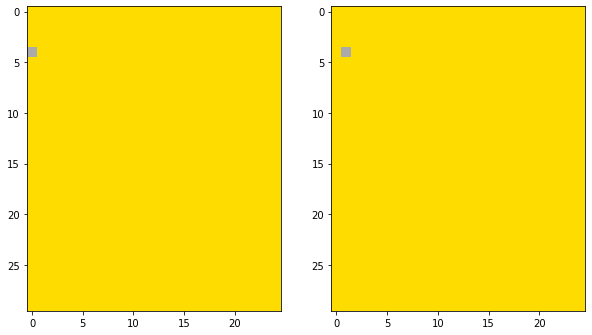

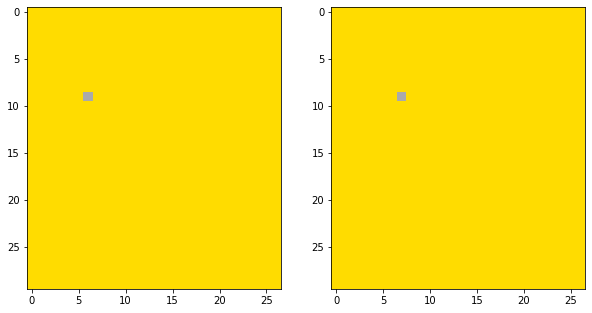

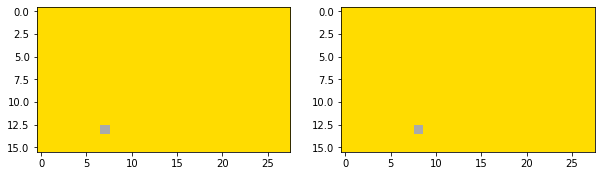

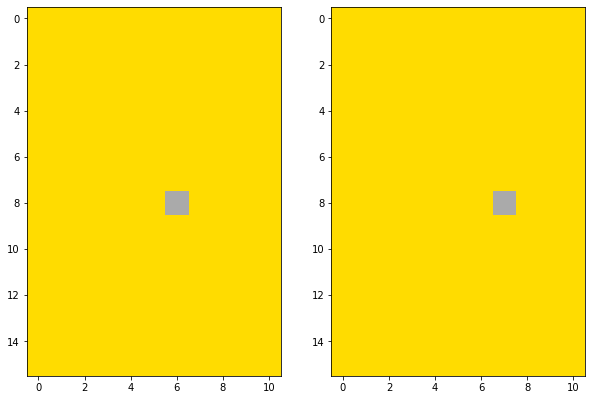

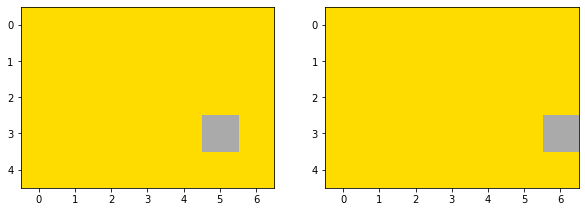

In [15]:
# For each task we create 4-5 pairs.
# Then package them up as 1 or 2 'test' task, with 2-3 'train' task.
seed = 1
# task = CircleAPixel(seed,1)
task = MoveAPixelX(seed,1)
modifier='one'
tkid = IdGenerator(seed)

task_class=task.__class__.__name__.lower()+modifier
data_dir='data/core_knowledge/'+task_class+'/'
if not os.path.exists(data_dir):
   os.makedirs(data_dir)

num_tasks = 1000
for t in range(num_tasks):
    data = task.generate() # Need a name
    if t == 0: 
        for i in range(len(data['train'])): plot_iopair(data['train'][i], "")               
        for i in range(len(data['test'])): plot_iopair(data['test'][i], "") 
    # Saves this into a json file.
    task_id = tkid.generate()
    task_file = data_dir + task_class + '-' + task_id + '.json' 
    if t % int(num_tasks / 10) == 0: print("processed",t,task_file)    
    with open(task_file, 'w') as f:
        json.dump(data, f)